In [1]:
import torch
from torchvision.models.efficientnet import efficientnet_v2_s
import sys
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, classification_report
import matplotlib.pyplot as plt
sys.path.append("../")
from utils import CustomDataset, EfficientNet_transform

In [2]:
efficientnet_model = efficientnet_v2_s()
efficientnet_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2),
    torch.nn.SELU(),
    torch.nn.Linear(in_features=1280, out_features=1)
)
efficientnet_model.load_state_dict(torch.load("../Models/FinetunedEfficientNet.pth"))

<All keys matched successfully>

In [3]:
data = CustomDataset("../Data/test.csv", "../Data/Images", "Filename", "Target", transform=EfficientNet_transform)
dl = torch.utils.data.DataLoader(data, 16, True)

In [4]:
total_params = sum(p.numel() for p in efficientnet_model.parameters())
print(f"Total Parameters: {total_params}")

Total Parameters: 20178769


In [5]:
efficientnet_true_labels = []
efficientnet_pred_labels = []
probabilities = []
efficientnet_model.eval()
with torch.inference_mode():
    for batch, labels in dl:
        outputs = efficientnet_model(batch)
        probs = torch.sigmoid(outputs)
        preds = torch.round(probs)
        efficientnet_true_labels.extend(labels.cpu().numpy())
        efficientnet_pred_labels.extend(preds.cpu().numpy())
        probabilities.extend(probs.cpu().numpy())

efficientnet_true_labels = np.array(efficientnet_true_labels)
efficientnet_pred_labels = np.array(efficientnet_pred_labels)
probabilities = np.array(probabilities)

efficientnet_accuracy = accuracy_score(efficientnet_true_labels, efficientnet_pred_labels)

print(f'Accuracy: {efficientnet_accuracy * 100:.2f}%')

C:\Users\Prash\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy: 100.00%


In [6]:
print(classification_report(efficientnet_true_labels, efficientnet_pred_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       238
           1       1.00      1.00      1.00       191

    accuracy                           1.00       429
   macro avg       1.00      1.00      1.00       429
weighted avg       1.00      1.00      1.00       429



<Figure size 960x720 with 0 Axes>

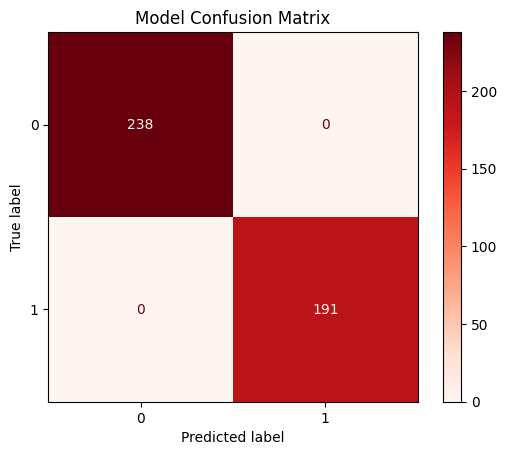

In [8]:
cm = confusion_matrix(efficientnet_true_labels, efficientnet_pred_labels)

# Create a confusion matrix display
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# Display the confusion matrix using seaborn
plt.figure(dpi=150)
cmd.plot(cmap="Reds")
plt.title("Model Confusion Matrix")
plt.show()

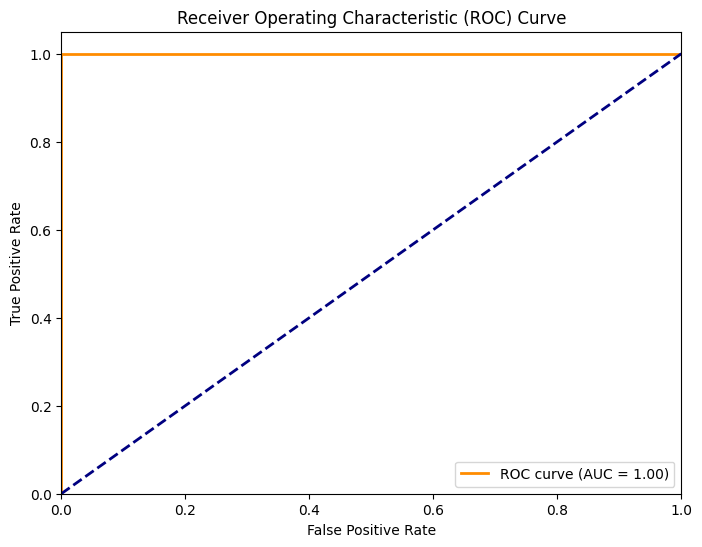

In [9]:
fpr, tpr, thresholds = roc_curve(efficientnet_true_labels, probabilities)

# Calculate the AUC score
roc_auc = roc_auc_score(efficientnet_true_labels, efficientnet_pred_labels)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()